# Problema 1 - Previsão de Séries Temporais Complexas com RNN Vanilla

Este notebook demonstra um caso onde a **RNN Vanilla funciona bem**. Vamos prever uma série temporal que combina múltiplos padrões: diferentes frequências senoidais, tendência linear e ruído gaussiano.

## Objetivo
Treinar uma RNN para prever o próximo valor de uma sequência temporal complexa que combina:
- Múltiplas ondas senoidais com frequências diferentes
- Tendência de crescimento/decrescimento
- Ruído aleatório para simular dados do mundo real

In [29]:
# 1. Importar bibliotecas necessárias
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Configurar seed para reprodutibilidade
np.random.seed(42)
tf.random.set_seed(42)

## 1. Geração dos Dados

Vamos criar uma série temporal mais complexa que simula dados do mundo real. A série combinará:
- Uma onda senoidal de baixa frequência (ciclo longo)
- Uma onda senoidal de alta frequência (oscilação rápida)
- Uma tendência linear ascendente
- Ruído gaussiano

Total de pontos gerados: 1000
Intervalo de valores: [-1.20, 3.20]


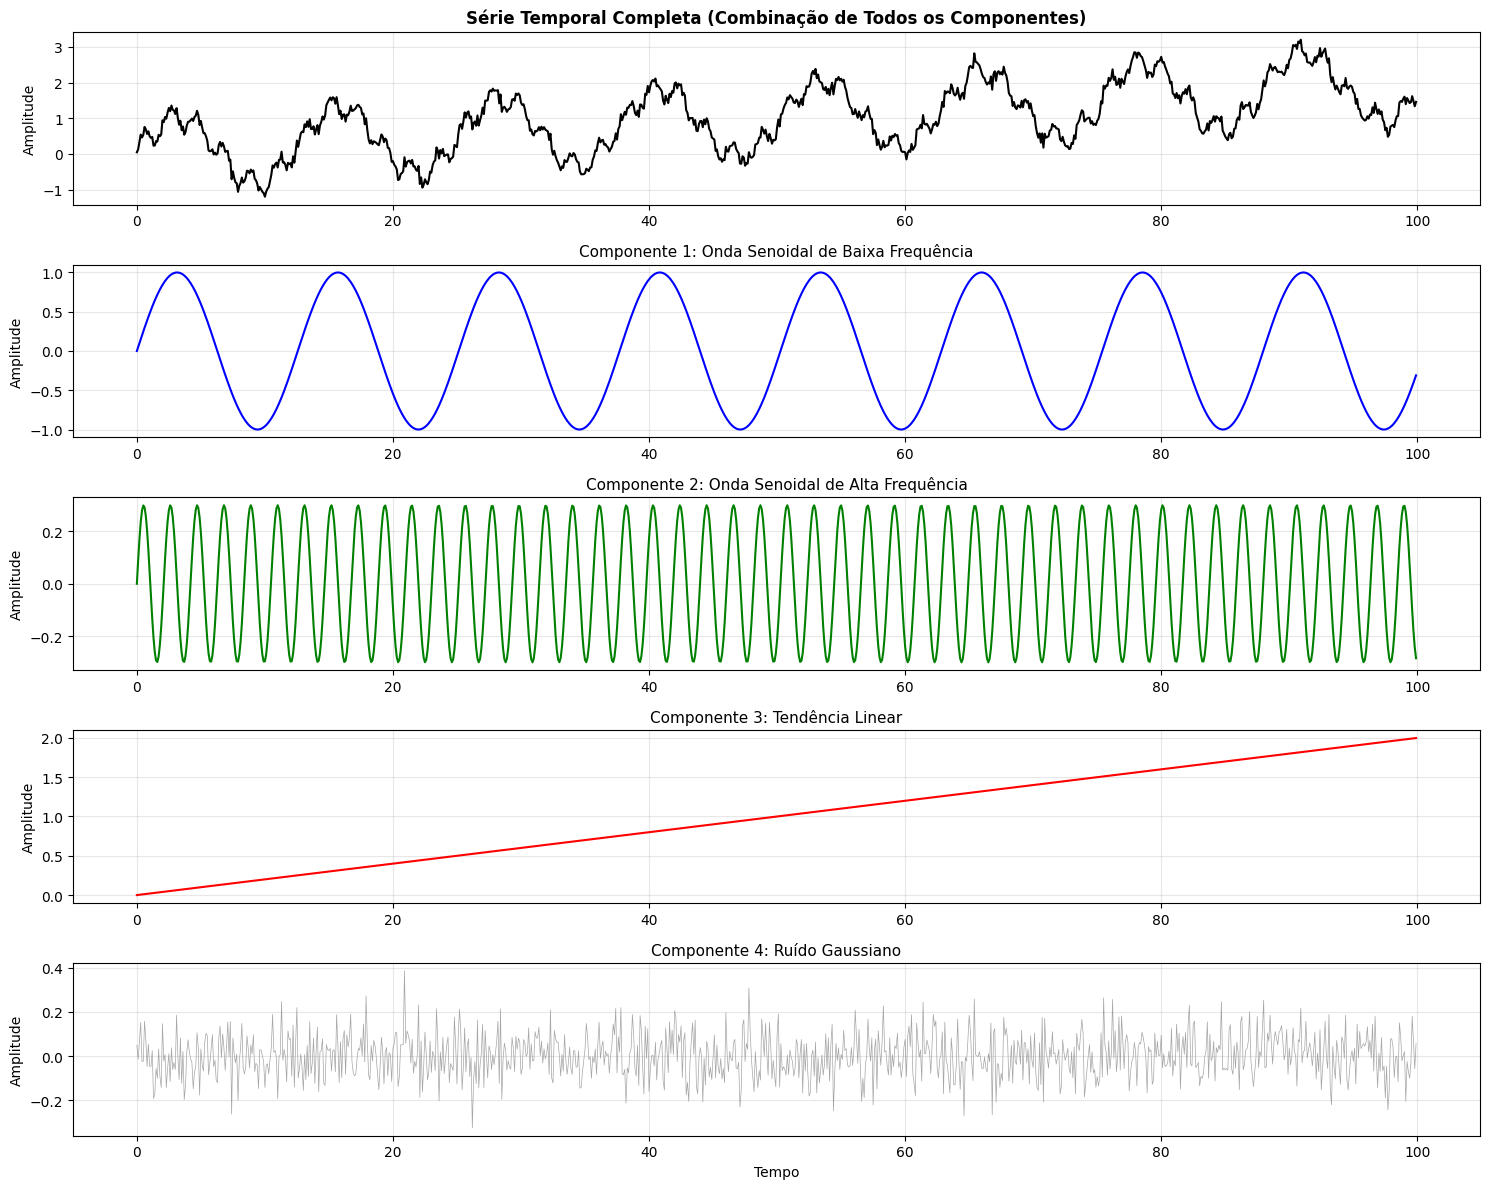


Estatísticas da série:
Média: 1.0029
Desvio padrão: 0.9016
Mínimo: -1.1969
Máximo: 3.2030


In [30]:
# Gerar série temporal complexa
t = np.arange(0, 100, 0.1)

# Componente 1: Onda senoidal de baixa frequência (ciclo longo)
low_freq = np.sin(t * 0.5)

# Componente 2: Onda senoidal de alta frequência (oscilação rápida)
high_freq = 0.3 * np.sin(t * 3)

# Componente 3: Tendência linear ascendente
trend = 0.02 * t

# Componente 4: Ruído gaussiano
noise = np.random.normal(0, 0.1, len(t))

# Combinar todos os componentes
series = low_freq + high_freq + trend + noise

print(f"Total de pontos gerados: {len(series)}")
print(f"Intervalo de valores: [{series.min():.2f}, {series.max():.2f}]")

# Visualizar a série temporal e seus componentes
fig, axes = plt.subplots(5, 1, figsize=(15, 12))

# Série completa
axes[0].plot(t, series, linewidth=1.5, color='black')
axes[0].set_title('Série Temporal Completa (Combinação de Todos os Componentes)', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Amplitude')
axes[0].grid(True, alpha=0.3)

# Componente 1: Baixa frequência
axes[1].plot(t, low_freq, linewidth=1.5, color='blue')
axes[1].set_title('Componente 1: Onda Senoidal de Baixa Frequência', fontsize=11)
axes[1].set_ylabel('Amplitude')
axes[1].grid(True, alpha=0.3)

# Componente 2: Alta frequência
axes[2].plot(t, high_freq, linewidth=1.5, color='green')
axes[2].set_title('Componente 2: Onda Senoidal de Alta Frequência', fontsize=11)
axes[2].set_ylabel('Amplitude')
axes[2].grid(True, alpha=0.3)

# Componente 3: Tendência
axes[3].plot(t, trend, linewidth=1.5, color='red')
axes[3].set_title('Componente 3: Tendência Linear', fontsize=11)
axes[3].set_ylabel('Amplitude')
axes[3].grid(True, alpha=0.3)

# Componente 4: Ruído
axes[4].plot(t, noise, linewidth=0.5, color='gray', alpha=0.7)
axes[4].set_title('Componente 4: Ruído Gaussiano', fontsize=11)
axes[4].set_xlabel('Tempo')
axes[4].set_ylabel('Amplitude')
axes[4].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\nEstatísticas da série:")
print(f"Média: {series.mean():.4f}")
print(f"Desvio padrão: {series.std():.4f}")
print(f"Mínimo: {series.min():.4f}")
print(f"Máximo: {series.max():.4f}")

## 2. Preparação das Sequências

Vamos criar sequências de entrada (X) e saída (y) para treinar o modelo. Cada X contém uma janela de pontos consecutivos, e y é o próximo ponto da sequência.

Shape de X: (990, 10, 1)
Shape de y: (990,)

Exemplo de uma sequência:
Entrada (X): [0.04967142 0.1268088  0.33799501 0.54273919 0.46286572]... (primeiros 5 valores)
Saída (y): 0.495419771740917


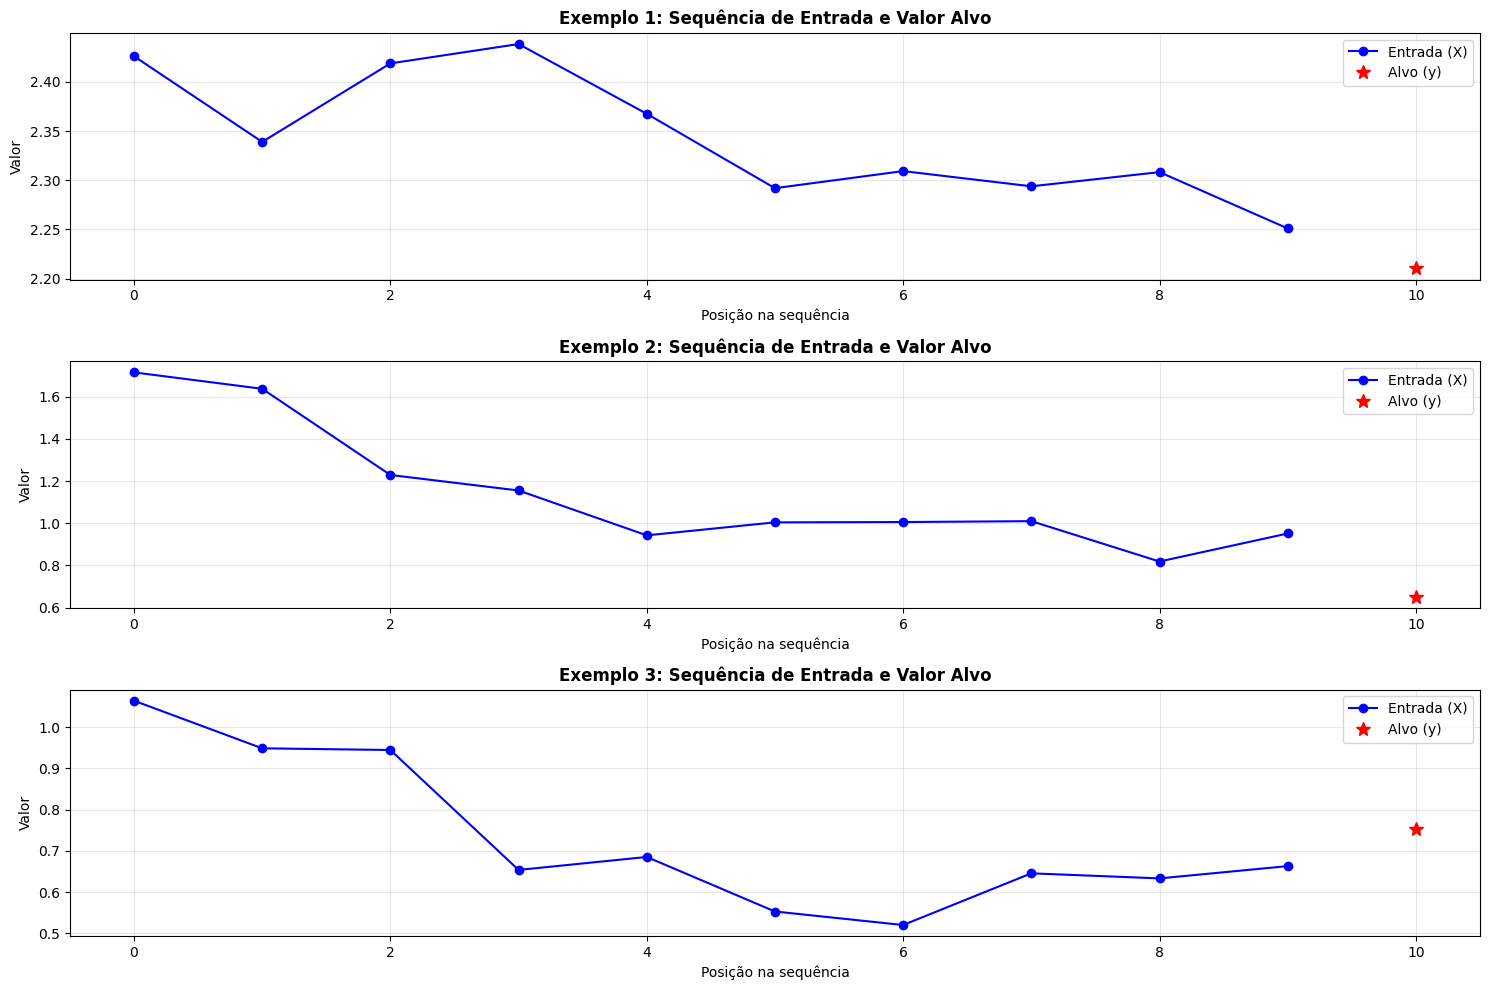

In [31]:
def create_sequences(data, window_size):
    """
    Cria sequências de treino a partir dos dados.
    
    Args:
        data: Array com os dados da série temporal
        window_size: Tamanho da janela de entrada
    
    Returns:
        X: Sequências de entrada
        y: Valores alvo (próximo ponto)
    """
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i + window_size])
        y.append(data[i + window_size])
    return np.array(X), np.array(y)

# Definir tamanho da janela
window_size = 10

# Criar sequências
X, y = create_sequences(series, window_size)

# Reshape para formato esperado pela RNN: (samples, timesteps, features)
X = X.reshape((X.shape[0], X.shape[1], 1))

print(f"Shape de X: {X.shape}")
print(f"Shape de y: {y.shape}")
print(f"\nExemplo de uma sequência:")
print(f"Entrada (X): {X[0].flatten()[:5]}... (primeiros 5 valores)")
print(f"Saída (y): {y[0]}")

# Visualizar alguns exemplos de sequências
n_examples = 3
plt.figure(figsize=(15, 10))

for i in range(n_examples):
    plt.subplot(n_examples, 1, i+1)
    
    # Índice aleatório para selecionar um exemplo
    example_idx = np.random.randint(0, len(X))
    
    # Plotar a sequência de entrada (X)
    plt.plot(range(window_size), X[example_idx].flatten(), 'b-o', label='Entrada (X)')
    
    # Plotar o valor alvo (y)
    plt.plot(window_size, y[example_idx], 'r*', markersize=10, label='Alvo (y)')
    
    plt.title(f'Exemplo {i+1}: Sequência de Entrada e Valor Alvo', fontsize=12, fontweight='bold')
    plt.xlabel('Posição na sequência')
    plt.ylabel('Valor')
    plt.grid(True, alpha=0.3)
    plt.legend()

plt.tight_layout()
plt.show()

## 3. Divisão Treino/Teste

Para séries temporais, **não embaralhamos** os dados. Usamos os primeiros 80% para treino e os últimos 20% para teste.

In [32]:
# Dividir em treino e teste (80% treino, 20% teste)
split_idx = int(0.8 * len(X))

X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

print(f"Dados de treino: {len(X_train)} sequências")
print(f"Dados de teste: {len(X_test)} sequências")
print(f"\nProporção treino/teste: {len(X_train)/len(X)*100:.1f}% / {len(X_test)/len(X)*100:.1f}%")

Dados de treino: 792 sequências
Dados de teste: 198 sequências

Proporção treino/teste: 80.0% / 20.0%


## 4. Construção do Modelo RNN Simples

Vamos criar uma arquitetura bem simples com uma camada SimpleRNN e uma camada Dense de saída.

In [33]:
# Construir o modelo
model = Sequential([
    SimpleRNN(32, input_shape=(window_size, 1), activation='tanh'),
    Dense(1)
])

# Compilar o modelo
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

# Visualizar a arquitetura
model.summary()

/home/leonardopn/Documents/Git/UFSM/rnn-lstm-presentation/.venv/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn_2 (SimpleRNN)        │ (None, 32)             │         1,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,121 (4.38 KB)

 Trainable params: 1,121 (4.38 KB)

 Non-trainable params: 0 (0.00 B)

## 5. Treinamento do Modelo

Vamos treinar o modelo por 30 épocas. Mesmo com uma série temporal mais complexa, a RNN Vanilla ainda consegue aprender padrões de curto alcance eficientemente!

In [34]:
# Treinar o modelo
history = model.fit(
    X_train, y_train,
    epochs=30,
    batch_size=32,
    validation_data=(X_test, y_test),
    verbose=1
)

Epoch 1/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - loss: 1.1874 - mae: 0.8068 - val_loss: 0.7353 - val_mae: 0.6429
Epoch 2/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - loss: 1.1874 - mae: 0.8068 - val_loss: 0.7353 - val_mae: 0.6429
Epoch 2/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1722 - mae: 0.3238 - val_loss: 0.2593 - val_mae: 0.3799
Epoch 3/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1722 - mae: 0.3238 - val_loss: 0.2593 - val_mae: 0.3799
Epoch 3/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0897 - mae: 0.2371 - val_loss: 0.1748 - val_mae: 0.3073
Epoch 4/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0897 - mae: 0.2371 - val_loss: 0.1748 - val_mae: 0.3073
Epoch 4/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0632 - mae: 0.1947 - val_loss: 0.1243 - val_mae: 0.2625
Epoch 5/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0632 - mae: 0.1947 - val_loss: 0.1243 - val_mae: 0.2625
Epoch 5/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0506 - mae

### Visualização das Curvas de Aprendizado

Vamos ver como o modelo aprendeu ao longo das épocas.

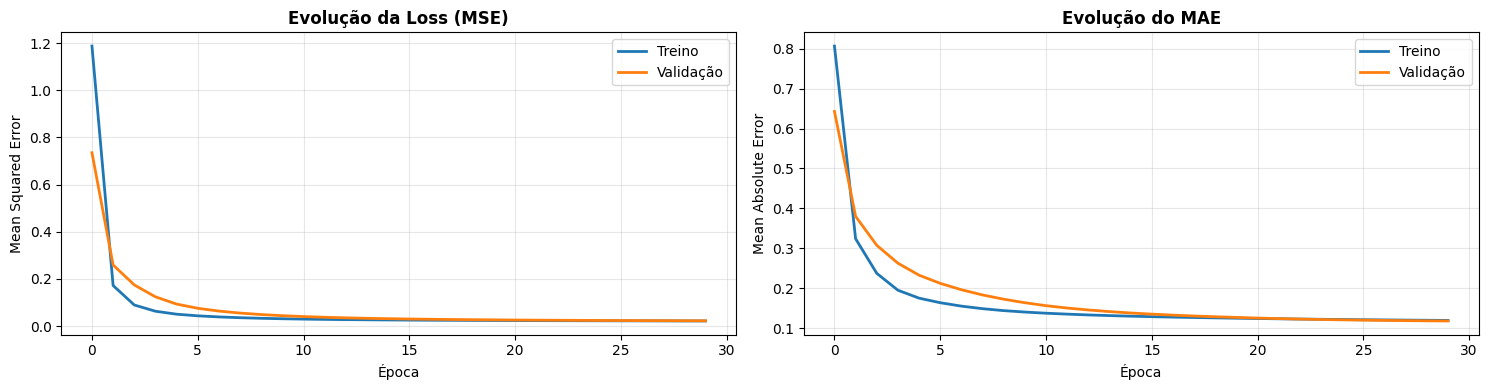


Resultados Finais:
Loss final (treino): 0.021862
Loss final (validação): 0.022612
MAE final (treino): 0.119056
MAE final (validação): 0.117647


In [35]:
# Plotar curvas de aprendizado
fig, axes = plt.subplots(1, 2, figsize=(15, 4))

# Loss
axes[0].plot(history.history['loss'], label='Treino', linewidth=2)
axes[0].plot(history.history['val_loss'], label='Validação', linewidth=2)
axes[0].set_title('Evolução da Loss (MSE)', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Época')
axes[0].set_ylabel('Mean Squared Error')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# MAE
axes[1].plot(history.history['mae'], label='Treino', linewidth=2)
axes[1].plot(history.history['val_mae'], label='Validação', linewidth=2)
axes[1].set_title('Evolução do MAE', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Época')
axes[1].set_ylabel('Mean Absolute Error')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nResultados Finais:")
print(f"Loss final (treino): {history.history['loss'][-1]:.6f}")
print(f"Loss final (validação): {history.history['val_loss'][-1]:.6f}")
print(f"MAE final (treino): {history.history['mae'][-1]:.6f}")
print(f"MAE final (validação): {history.history['val_mae'][-1]:.6f}")

## 6. Avaliação e Visualização

Vamos fazer previsões e visualizar como o modelo aprendeu a reproduzir o padrão da onda senoidal.

In [45]:
# Fazer previsões no conjunto de teste
y_pred = model.predict(X_test, verbose=0)

# Calcular métricas
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mse)

print(f"Métricas no Conjunto de Teste:")
print(f"MSE (Mean Squared Error): {mse:.6f}")
print(f"RMSE (Root Mean Squared Error): {rmse:.6f}")
print(f"MAE (Mean Absolute Error): {mae:.6f}")
print(f"\nErro médio de {mae:.4f} em uma série com amplitude de {series.max() - series.min():.2f}!")
print(f"Isso representa {(mae/(series.max() - series.min()))*100:.2f}% do range total dos dados.")

Métricas no Conjunto de Teste:
MSE (Mean Squared Error): 0.022612
RMSE (Root Mean Squared Error): 0.150374
MAE (Mean Absolute Error): 0.117647

Erro médio de 0.1176 em uma série com amplitude de 4.40!
Isso representa 2.67% do range total dos dados.


### Visualização: Valores Reais vs Previsões

O gráfico abaixo mostra a sobreposição quase perfeita entre os valores reais e as previsões do modelo.

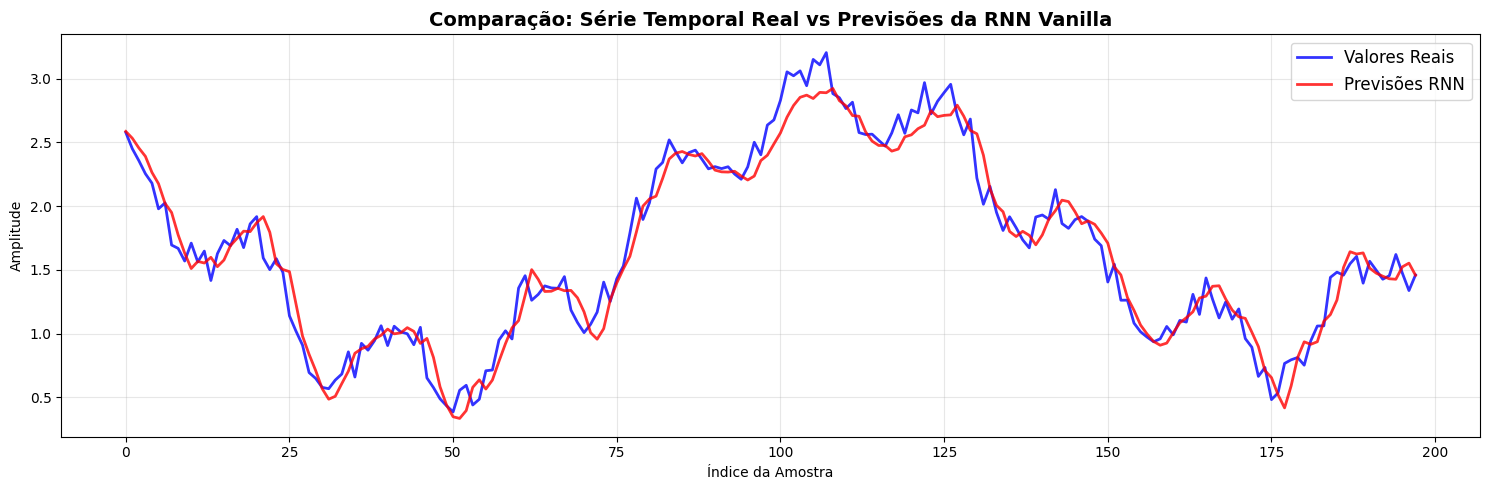

In [47]:
# Plotar valores reais vs previsões
plt.figure(figsize=(15, 5))
plt.plot(y_test, label='Valores Reais', linewidth=2, alpha=0.8, color='blue')
plt.plot(y_pred, label='Previsões RNN', linewidth=2, alpha=0.8, color='red')
plt.title('Comparação: Série Temporal Real vs Previsões da RNN Vanilla', fontsize=14, fontweight='bold')
plt.xlabel('Índice da Amostra')
plt.ylabel('Amplitude')
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### Visualização Ampliada: Detalhes da Precisão

Vamos dar um zoom em uma porção menor para ver melhor a qualidade das previsões.

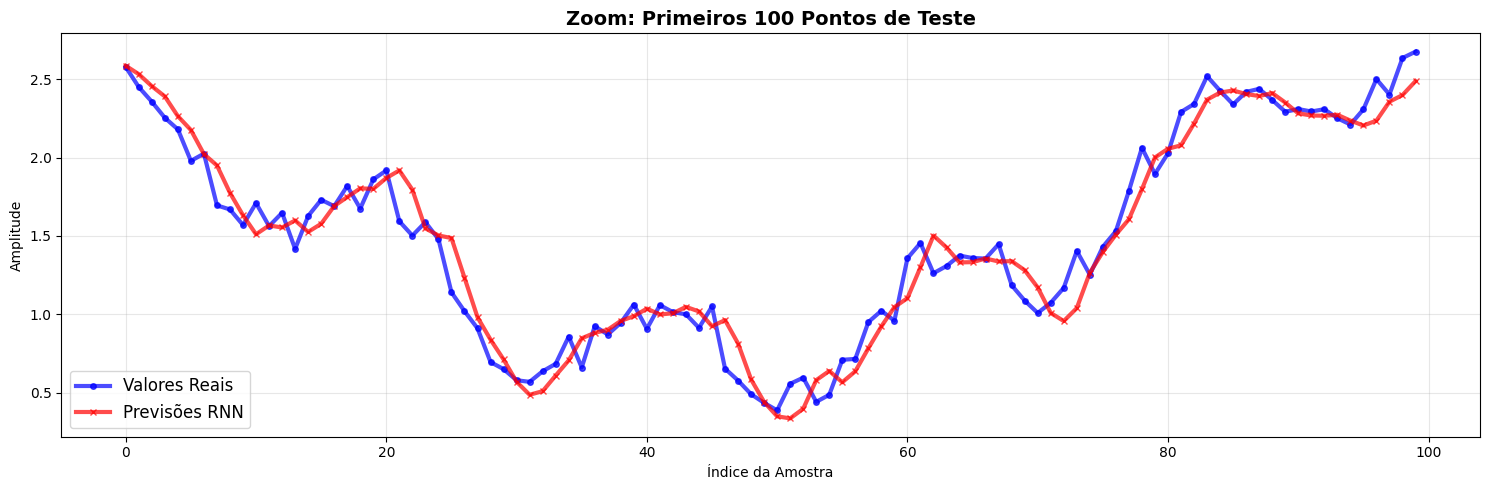

In [49]:
# Visualizar uma porção menor para ver detalhes
sample_size = 100
plt.figure(figsize=(15, 5))
plt.plot(y_test[:sample_size], label='Valores Reais', linewidth=3, alpha=0.7, color='blue', marker='o', markersize=4)
plt.plot(y_pred[:sample_size], label='Previsões RNN', linewidth=3, alpha=0.7, color='red', marker='x', markersize=4)
plt.title(f'Zoom: Primeiros {sample_size} Pontos de Teste', fontsize=14, fontweight='bold')
plt.xlabel('Índice da Amostra')
plt.ylabel('Amplitude')
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()